# 1D spectral extraction using aperture photometry on a point source observation
In this notebook we illustrate how to perform aperture photometry on LVL2 MRS data products (slope detector images). The algorithm is applied to a point source observation of an 800K blackbody source observed in all MRS spectral bands.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import pkg_resources
import sys
sys.path.append('../functions')
sys.path.append('../data')

import funcs
from distortionMaps import d2cMapping
from shapely.geometry import Point
import shapely.affinity

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/patrickkavanagh/mirisim/testing/additional_fringes/step-by-step/optimal/'
cdpDir  = '/Users/patrickkavanagh/CDP_dir/'
lvl2path  = '/Users/patrickkavanagh/mirisim/testing/additional_fringes/step-by-step/MRS_fullband_no-effects_no-dither_pipelined/'


In [7]:
# Define filename of observation in selected MRS band
sci_files = {"1A":lvl2path +'det_image_seq1_MIRIFUSHORT_12SHORTexp1_assign_wcs.fits',
            "1B":lvl2path +'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_assign_wcs.fits',
            "1C":lvl2path +'det_image_seq1_MIRIFUSHORT_12LONGexp1_assign_wcs.fits',
            "2A":lvl2path +'det_image_seq1_MIRIFUSHORT_12SHORTexp1_assign_wcs.fits',
            "2B":lvl2path +'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_assign_wcs.fits',
            "2C":lvl2path +'det_image_seq1_MIRIFUSHORT_12LONGexp1_assign_wcs.fits',
            "3A":lvl2path +'det_image_seq1_MIRIFULONG_34SHORTexp1_assign_wcs.fits',
            "3B":lvl2path +'det_image_seq1_MIRIFULONG_34MEDIUMexp1_assign_wcs.fits',
            "3C":lvl2path +'det_image_seq1_MIRIFULONG_34LONGexp1_assign_wcs.fits',
            "4A":lvl2path +'det_image_seq1_MIRIFULONG_34SHORTexp1_assign_wcs.fits',
            "4B":lvl2path +'det_image_seq1_MIRIFULONG_34MEDIUMexp1_assign_wcs.fits',
            "4C":lvl2path +'det_image_seq1_MIRIFULONG_34LONGexp1_assign_wcs.fits'}



In [10]:
# wavelength,aperture_extracted_signal = {},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    if band[0] == '4': fit = '1D'
    else: fit = '2D'
        
    # Get data
    hdulist_sci   = fits.open(sci_files[band])
    source_signal = hdulist_sci[1].data
    background_signal = 0

    # load distortion map on detector plane
    d2cMaps  = d2cMapping(band,cdpDir)
    det_dims = (1024,1032)

    # load CDPS
    fringe_img,photom_img,pixsiz_img,psffits,specres_table = funcs.get_cdps(band,cdpDir,output='img')

    # reduce LVL2 data to LVL3 data
    source_signal_subtrbkg  = source_signal - background_signal     # [DN/s/pix_{ij}]
    source_signal_divfringe = source_signal_subtrbkg/fringe_img     # [DN/s/pix_{ij}]
    source_signal_divphotom = source_signal_divfringe/photom_img    # [mJy/pix] (note here that the ij subscript has disappeared as the flat field division has changed the normalization to an average pixel area and responsivity)

    # create spectral grid on detector
    lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)

    eighty_percent_encircled_energy_fraction = funcs.load_obj('eighty_percent_encircled_energy_fraction')
    radius = np.average(eighty_percent_encircled_energy_fraction[band])

    if band[0] == '4':
        sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal_subtrbkg,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit)
        if len(np.where(np.isnan(sign_amp)==True)[0]) > len(lambcens)/2:
            # too many nans.. last attempt
            sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal_subtrbkg,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit,center=[d2cMaps['nslices']/2,0.])
    else:
        sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal_divfringe,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit)

    source_alpha_center = np.mean(alpha_centers[~np.isnan(alpha_centers)])
    source_beta_center  = np.mean(beta_centers[~np.isnan(beta_centers)])

    # define aperture shape
    # 1st elem = center point (x,y) coordinates
    # 2nd elem = the two semi-axis values (along x, along y)
    # 3rd elem = angle in degrees between x-axis of the Cartesian base
    #            and the corresponding semi-axis
    ellipse = ((source_alpha_center, source_beta_center),(1,1),0)

    # Let create a circle of radius 1 around center point:
    circ = shapely.geometry.Point(ellipse[0]).buffer(radius)

    # Let create the ellipse along x and y:
    ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

    # Let rotate the ellipse (clockwise, x axis pointing right):
    ellr = shapely.affinity.rotate(ell,ellipse[2])

    # save final output as the aperture and calculate the aperture area
    aperture = ellr
    aperture_area = aperture.area

    # create weight map with the pixel signal contributions (percentage area overlap with defined aperture)
    weight_map = funcs.pixel_signal_contribution(d2cMaps,aperture,spec_grid=[lambcens,lambfwhms])

    # perform 1d aperture extraction
    extracted_signal = funcs.aperture_weighted_photometry_point_source(source_signal_divphotom,weight_map,d2cMaps,spec_grid=[lambcens,lambfwhms])

    # determine flux conservation normalization factor
    unique_betas = np.sort(np.unique(d2cMaps['betaMap'][(d2cMaps['sliceMap']>100*int(band[0])) & (d2cMaps['sliceMap']<100*(int(band[0])+1))]))

    norm_factor,spatial_sum,fov_bin = [np.zeros(len(lambcens)) for i in range(3)]
    for ibin in range(len(lambcens)):
        pixelsInBin = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
        fov_lims = [d2cMaps['alphaMap'][pixelsInBin].min(),d2cMaps['alphaMap'][pixelsInBin].max()]
        fov_bin[ibin]  = (unique_betas.max()-unique_betas.min())*(fov_lims[1]-fov_lims[0])
        spatial_sum[ibin] = pixsiz_img[pixelsInBin].sum()
        norm_factor[ibin] = (spatial_sum[ibin]/fov_bin[ibin])

    # aperture correction based on 80% encircled energy fraction radius
    extracted_signal *= 1.2

    # normalize aperture extracted signal
    extracted_signal /= norm_factor
    
    wavelength[band] = lambcens
    aperture_extracted_signal[band] = extracted_signal
    print ''
print 'DONE'

Band 1A
STEP 1: Rough centroiding
Slice 11 has the largest summed flux
Source position: beta = 0.0arcsec, alpha = -1.32arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,

ERROR:shapely.geos:IllegalArgumentException: EdgeEnd with coordinate nan nan invalid for node nan nan


The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 

ValueError: No Shapely geometry can be created from null value

<IPython.core.display.Javascript object>


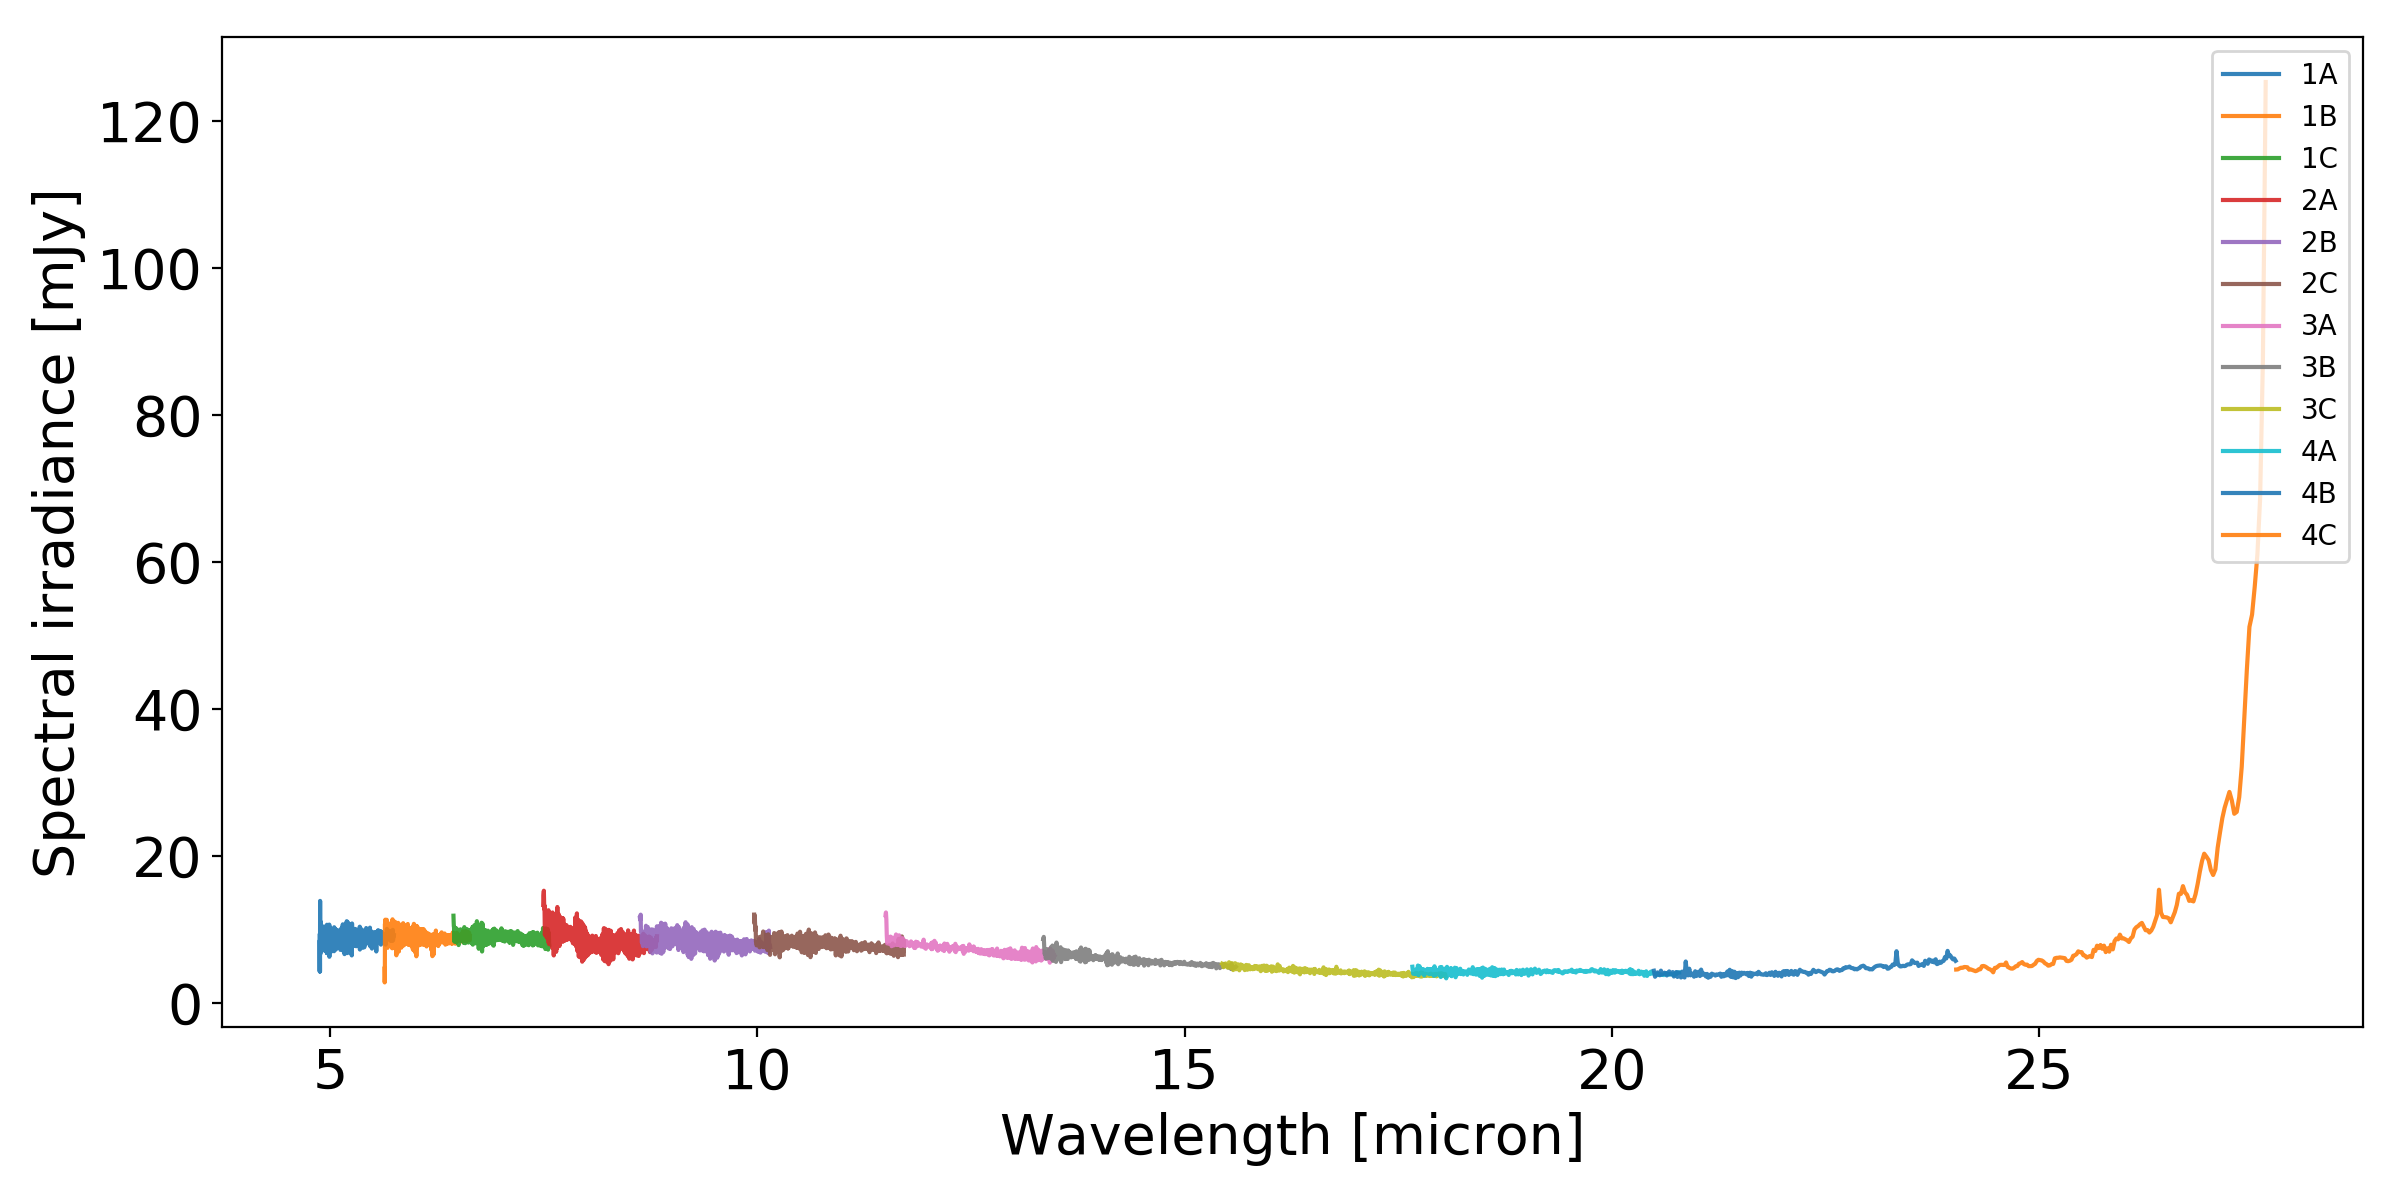

In [9]:
# plot extracted spectrum
plt.figure(figsize=(12,6))
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    plt.plot(wavelength[band][20:-20],aperture_extracted_signal[band][20:-20],alpha=0.9,label=band)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.legend(loc='upper right')
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()